<h2 style='color:green'>데이터 로딩 부분<h2>

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def load_motor_data(base_path, motor_numbers):
    data = {'normal': [], 'abnormal': []}

    for motor in motor_numbers:
        # 정상 데이터 경로
        normal_path = os.path.join(base_path, "normal", str(motor), "time_vib")
        if os.path.exists(normal_path):
            normal_files = [os.path.join(normal_path, file) for file in os.listdir(normal_path) if file.endswith('.csv')]
            for file in normal_files:
                df = pd.read_csv(file, header=None, names=['time', 'vibration'])
                data['normal'].append(df['vibration'].values)

        # 비정상 데이터 경로
        abnormal_path = os.path.join(base_path, "abnormal", str(motor), "time_vib")
        if os.path.exists(abnormal_path):
            abnormal_files = [os.path.join(abnormal_path, file) for file in os.listdir(abnormal_path) if file.endswith('.csv')]
            for file in abnormal_files:
                df = pd.read_csv(file, header=None, names=['time', 'vibration'])
                data['abnormal'].append(df['vibration'].values)

    return data


def split_train_validation(data, validation_ratio=0.2):
    """
    Train 데이터를 Train/Validation으로 분리
    """
    train_data = {'normal': [], 'abnormal': []}
    val_data = {'normal': [], 'abnormal': []}
    
    for category in ['normal', 'abnormal']:
        all_data = data[category]
        train_split, val_split = train_test_split(all_data, test_size=validation_ratio, random_state=42)
        train_data[category].extend(train_split)
        val_data[category].extend(val_split)
    
    return train_data, val_data


# Train/Test Split
train_motors = range(1, 17)  # 모터 1~16번: Train
test_motors = range(17, 21)  # 모터 17~20번: Test

base_path = "./motor_data"

# Train 데이터 로드
train_data = load_motor_data(base_path, train_motors)

# Train 데이터를 Train/Validation으로 분리
train_data, validation_data = split_train_validation(train_data, validation_ratio=0.2)

# Test 데이터 로드
test_data = load_motor_data(base_path, test_motors)

# 결과 확인
print("Train Data:", len(train_data['normal']), "normal,", len(train_data['abnormal']), "abnormal")
print("Validation Data:", len(validation_data['normal']), "normal,", len(validation_data['abnormal']), "abnormal")
print("Test Data:", len(test_data['normal']), "normal,", len(test_data['abnormal']), "abnormal")

Train Data: 1328 normal, 1332 abnormal
Validation Data: 333 normal, 334 abnormal
Test Data: 416 normal, 416 abnormal


<h2 style='color:green'>정상, 비정상 데이터 끼리 묶기<h2>

In [2]:
import numpy as np

# 데이터를 결합하는 함수
def combine_csv_data(data):
    """
    정상 데이터와 비정상 데이터를 각각 결합하여 반환합니다.
    """
    combined_data = {}
    combined_data['normal'] = np.concatenate(data['normal'])  # 정상 데이터 결합
    combined_data['abnormal'] = np.concatenate(data['abnormal'])  # 비정상 데이터 결합
    return combined_data

# 정상 데이터와 비정상 데이터를 하나로 묶는 함수
def combine_normal_and_abnormal(combined_data):
    """
    정상(normal)과 비정상(abnormal) 데이터를 하나의 배열로 결합하고,
    레이블을 함께 반환합니다.
    """
    # 데이터 결합
    combined = np.concatenate((combined_data['normal'], combined_data['abnormal']))
    
    # 레이블 생성 (정상: 0, 비정상: 1)
    labels = np.concatenate((
        np.zeros(len(combined_data['normal'])),  # 정상 레이블
        np.ones(len(combined_data['abnormal']))  # 비정상 레이블
    ))
    
    return combined, labels

# Train/Validation/Test 데이터 결합
train_combined = combine_csv_data(train_data)
validation_combined = combine_csv_data(validation_data)
test_combined = combine_csv_data(test_data)

# 정상과 비정상을 합치고 레이블 생성
train_features, train_labels = combine_normal_and_abnormal(train_combined)
validation_features, validation_labels = combine_normal_and_abnormal(validation_combined)
test_features, test_labels = combine_normal_and_abnormal(test_combined)

# 출력 테스트
print("Train Features Shape:", train_features.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Features Shape:", validation_features.shape)
print("Validation Labels Shape:", validation_labels.shape)
print("Test Features Shape:", test_features.shape)
print("Test Labels Shape:", test_labels.shape)


Train Features Shape: (2723840,)
Train Labels Shape: (2723840,)
Validation Features Shape: (683008,)
Validation Labels Shape: (683008,)
Test Features Shape: (851968,)
Test Labels Shape: (851968,)


In [3]:
normal = np.concatenate((train_combined['normal'],test_combined['normal']),axis=0)
abnormal = np.concatenate((train_combined['abnormal'],test_combined['abnormal']),axis=0)
df_normal = pd.DataFrame(normal,columns=['진동']) # 정상 데이터
df_abnormal = pd.DataFrame(abnormal,columns=['진동']) # 비정상 데이터

print("정상 데이터\n",df_normal.describe())
print("비정상 데이터\n",df_abnormal.describe()) 

정상 데이터
                  진동
count  1.785856e+06
mean  -3.655390e-08
std    1.906381e-01
min   -7.954600e-01
25%   -1.444200e-01
50%    9.070000e-03
75%    1.625600e-01
max    7.013000e-01
비정상 데이터
                  진동
count  1.789952e+06
mean   2.793371e-10
std    3.257801e-01
min   -1.027590e+00
25%   -2.573600e-01
50%    9.560000e-03
75%    2.401100e-01
max    9.693400e-01


<h2 style='color:green'>데이터 reshape<h2>

In [4]:
from sklearn.preprocessing import MinMaxScaler
"""
# Train/Test 데이터를 정규화
scaler = MinMaxScaler()
"""
train_normal = train_combined['normal'].reshape(-1)
test_normal = test_combined['normal'].reshape(-1)

train_abnormal = train_combined['abnormal'].reshape(-1)
test_abnormal = test_combined['abnormal'].reshape(-1)

train_normal = train_combined['normal'].reshape(-1)
test_normal = test_combined['normal'].reshape(-1)
validation_normal = validation_combined['normal'].reshape(-1)
validation_abnormal = validation_combined['abnormal'].reshape(-1)

train_normal

array([-0.14397, -0.02882,  0.08632, ..., -0.25818, -0.18142,  0.0105 ])

<h2 style='color:green'>데이터 슬라이싱 후 특징 추출<h2>

In [5]:
import numpy as np

# 슬라이딩 윈도우 방식의 데이터 슬라이싱 및 통계 feature 추출 함수
def extract_statistical_features_sliding(data, window_size=256, step=128):
    """
    데이터를 슬라이딩 윈도우 방식으로 자르고 통계적 특징을 추출합니다.
    :param data: 입력 데이터 (numpy array)
    :param window_size: 윈도우 크기
    :param step: 슬라이딩 간격
    :return: 슬라이싱된 데이터의 통계적 특징 (2D 배열)
    """
    features = []
    for i in range(0, len(data) - window_size + 1, step):
        slice_data = data[i:i + window_size]

        # 통계적 특징 추출
        mean = np.mean(slice_data)
        variance = np.var(slice_data)
        rms = np.sqrt(np.mean(slice_data**2))  # Root Mean Square
        skewness = np.mean((slice_data - mean)**3) / (np.std(slice_data)**3)  # 왜도
        kurtosis = np.mean((slice_data - mean)**4) / (np.std(slice_data)**4)  # 첨도

        # feature 추가
        features.append([mean, variance, rms, skewness, kurtosis])
    
    return np.array(features)

# 데이터 슬라이싱 및 feature 추출
train_normal_features = extract_statistical_features_sliding(train_normal, window_size=256, step=128)
validation_normal_features = extract_statistical_features_sliding(validation_normal, window_size=256, step=128)
test_normal_features = extract_statistical_features_sliding(test_normal, window_size=256, step=128)

train_abnormal_features = extract_statistical_features_sliding(train_abnormal, window_size=256, step=128)
validation_abnormal_features = extract_statistical_features_sliding(validation_abnormal, window_size=256, step=128)
test_abnormal_features = extract_statistical_features_sliding(test_abnormal, window_size=256, step=128)

# 결과 확인
print("Train Normal Features Shape:", train_normal_features.shape)
print("Validation Normal Features Shape:", validation_normal_features.shape)
print("Test Normal Features Shape:", test_normal_features.shape)

print("Train Abnormal Features Shape:", train_abnormal_features.shape)
print("Validation Abnormal Features Shape:", validation_abnormal_features.shape)
print("Test Abnormal Features Shape:", test_abnormal_features.shape)


Train Normal Features Shape: (10623, 5)
Validation Normal Features Shape: (2663, 5)
Test Normal Features Shape: (3327, 5)
Train Abnormal Features Shape: (10655, 5)
Validation Abnormal Features Shape: (2671, 5)
Test Abnormal Features Shape: (3327, 5)


In [6]:
normal_slice = np.concatenate((train_normal_features,test_normal_features),axis=0)
abnormal_slice = np.concatenate((train_abnormal_features,test_abnormal_features),axis=0)
print(normal_slice)

[[-9.37304687e-04  3.36812558e-02  1.83526931e-01  1.14450452e-02
   2.13179306e+00]
 [-1.98683594e-03  3.35027348e-02  1.83048306e-01  2.35082596e-03
   2.01312641e+00]
 [ 3.11058594e-03  3.41813295e-02  1.84908099e-01 -4.72097666e-02
   2.03882000e+00]
 ...
 [-6.37421875e-04  3.74769088e-02  1.93590586e-01  5.73588052e-02
   1.84414561e+00]
 [ 1.16199219e-03  3.59799763e-02  1.89687444e-01 -1.73958079e-03
   2.15206289e+00]
 [-4.87500000e-04  3.52757356e-02  1.87818991e-01  4.21228464e-02
   2.25681810e+00]]


<h1></h1>

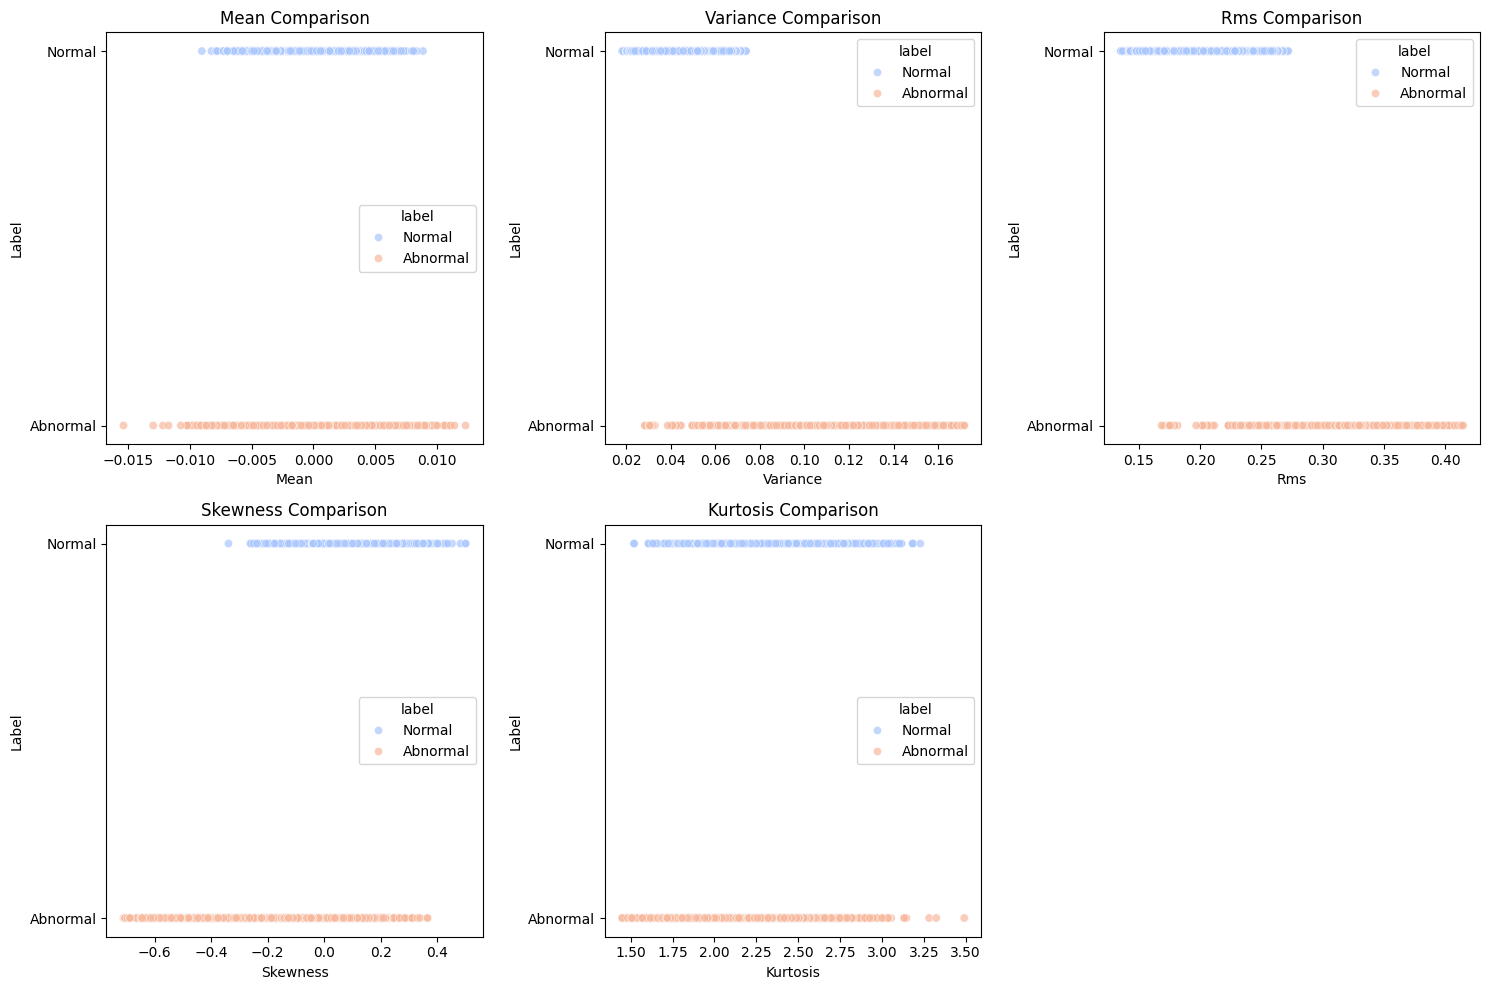

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 통계적 특징을 DataFrame으로 변환
def create_feature_dataframe(features, label):
    df = pd.DataFrame(features, columns=['mean', 'variance', 'rms', 'skewness', 'kurtosis'])
    df['label'] = label
    return df

# 정상 데이터와 비정상 데이터의 통계적 특징을 DataFrame으로 변환
df_train_normal = create_feature_dataframe(train_normal_features, 'Normal')
df_train_abnormal = create_feature_dataframe(train_abnormal_features, 'Abnormal')

# 두 DataFrame을 결합
df_combined = pd.concat([df_train_normal, df_train_abnormal], ignore_index=True)

# 각 특징을 비교하는 scatter plot 생성
features = ['mean', 'variance', 'rms', 'skewness', 'kurtosis']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=feature, y='label', data=df_combined, hue='label', palette='coolwarm', alpha=0.7)
    plt.title(f'{feature.capitalize()} Comparison')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Label')

plt.tight_layout()
plt.show()

<h2 style='color:green'>BOX PLOT<h2>

/tmp/ipykernel_8551/612072221.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_combined, palette='coolwarm')
/tmp/ipykernel_8551/612072221.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_combined, palette='coolwarm')
/tmp/ipykernel_8551/612072221.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_combined, palette='coolwarm')
/tmp/ipykernel_8551/612072221.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will

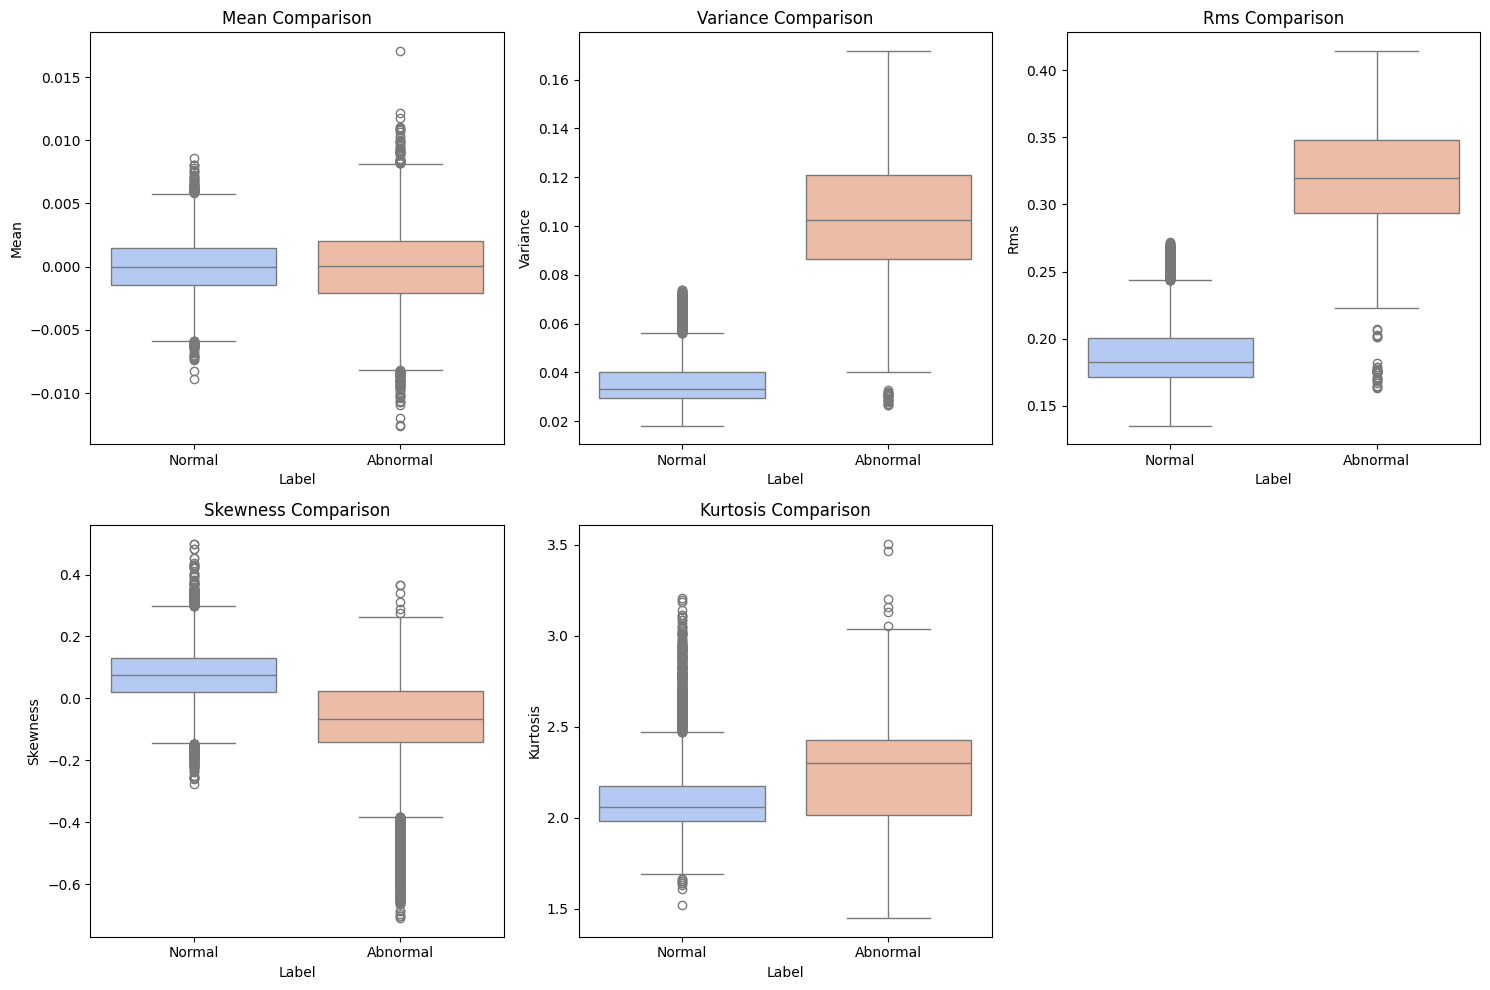

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 통계적 특징을 DataFrame으로 변환하는 함수
def create_feature_dataframe(features, label):
    df = pd.DataFrame(features, columns=['mean', 'variance', 'rms', 'skewness', 'kurtosis'])
    df['label'] = label
    return df

# 정상 데이터와 비정상 데이터의 통계적 특징을 DataFrame으로 변환
df_train_normal = create_feature_dataframe(train_normal_features, 'Normal')
df_train_abnormal = create_feature_dataframe(train_abnormal_features, 'Abnormal')

# 두 DataFrame을 결합
df_combined = pd.concat([df_train_normal, df_train_abnormal], ignore_index=True)

# 각 특징을 비교하는 박스 플롯 생성
features = ['mean', 'variance', 'rms', 'skewness', 'kurtosis']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='label', y=feature, data=df_combined, palette='coolwarm')
    plt.title(f'{feature.capitalize()} Comparison')
    plt.xlabel('Label')
    plt.ylabel(feature.capitalize())

plt.tight_layout()
plt.show()

variance랑 rms가 겹침이 적어 학습 데이터셋으로 적합한 것 같습니다

<h2 style='color:pink'>모델 설정 및 학습<h2>

All features

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 데이터 준비
X_train = train_normal_features
X_test = test_normal_features

# Autoencoder 모델 정의
input_dim = X_train.shape[1]  # feature 개수
encoding_dim = 2  # 압축된 차원 (조정 가능)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder 모델 생성
autoencoder = models.Model(input_layer, decoded)

# 모델 컴파일
autoencoder.compile(optimizer="adam", loss="mse")

# 모델 학습
history = autoencoder.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1   
)

# 모델 평가
print("Training Complete!")


Epoch 1/50
332/332 [==============================] - 0s 1ms/step - loss: 0.5301 - val_loss: 0.3601
Epoch 2/50
332/332 [==============================] - 0s 900us/step - loss: 0.3473 - val_loss: 0.2528
Epoch 3/50
332/332 [==============================] - 0s 788us/step - loss: 0.2840 - val_loss: 0.2241
Epoch 4/50
332/332 [==============================] - 0s 784us/step - loss: 0.2668 - val_loss: 0.2150
Epoch 5/50
332/332 [==============================] - 0s 790us/step - loss: 0.2607 - val_loss: 0.2113
Epoch 6/50
332/332 [==============================] - 0s 779us/step - loss: 0.2580 - val_loss: 0.2095
Epoch 7/50
332/332 [==============================] - 0s 842us/step - loss: 0.2565 - val_loss: 0.2085
Epoch 8/50
332/332 [==============================] - 0s 774us/step - loss: 0.2557 - val_loss: 0.2079
Epoch 9/50
332/332 [==============================] - 0s 901us/step - loss: 0.2551 - val_loss: 0.2075
Epoch 10/50
332/332 [==============================] - 0s 779us/step - loss: 0.2548 

variance, rms,skewness train

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# 데이터 준비
# train_normal_features와 test_normal_features에서 variance, rms, skewness 피쳐만 선택
X_train = train_normal_features[:, [1, 2, 3]]  # variance, rms, skewness
X_test = test_normal_features[:, [1, 2, 3]]    # variance, rms, skewness

# Autoencoder 모델 정의
input_dim = X_train.shape[1]  # feature 개수 (3개)
encoding_dim = 2  # 압축된 차원 (조정 가능)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder 모델 생성
autoencoder_second = models.Model(input_layer, decoded)

# 모델 컴파일
autoencoder_second.compile(optimizer="adam", loss="mse")

# 모델 학습
history = autoencoder_second.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1   
)

# 모델 평가
print("Training Complete!")

Epoch 1/50
332/332 [==============================] - 0s 895us/step - loss: 0.0986 - val_loss: 0.0437
Epoch 2/50
332/332 [==============================] - 0s 778us/step - loss: 0.0199 - val_loss: 0.0091
Epoch 3/50
332/332 [==============================] - 0s 787us/step - loss: 0.0061 - val_loss: 0.0046
Epoch 4/50
332/332 [==============================] - 0s 810us/step - loss: 0.0041 - val_loss: 0.0035
Epoch 5/50
332/332 [==============================] - 0s 808us/step - loss: 0.0035 - val_loss: 0.0031
Epoch 6/50
332/332 [==============================] - 0s 803us/step - loss: 0.0033 - val_loss: 0.0029
Epoch 7/50
332/332 [==============================] - 0s 797us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 8/50
332/332 [==============================] - 0s 811us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/50
332/332 [==============================] - 0s 803us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 10/50
332/332 [==============================] - 0s 797us/step - loss: 0.002

<h2 style='color:green'>score<h2>

모든 feature들을 사용하였을 경우

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# 데이터 준비
X_train = train_normal_features  # Train 데이터
X_val = validation_normal_features  # Validation 정상 데이터
X_val_abnormal = validation_abnormal_features  # Validation 비정상 데이터
X_test = test_normal_features  # Test 정상 데이터
X_test_abnormal = test_abnormal_features  # Test 비정상 데이터

# Autoencoder 모델 정의
input_dim = X_train.shape[1]  # feature 개수
encoding_dim = 2  # 압축된 차원 (조정 가능)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder 모델 생성
autoencoder = models.Model(input_layer, decoded)

# 모델 컴파일
autoencoder.compile(optimizer="adam", loss="mse")

# 모델 학습
history = autoencoder.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val),  # Validation 데이터로 평가
    verbose=1
)

# 모델 학습 완료
print("Training Complete!")

# Validation 데이터 복원
reconstructed_val = autoencoder.predict(X_val)
reconstructed_val_abnormal = autoencoder.predict(X_val_abnormal)

# 재구성 오차 계산 => Validation 데이터
val_reconstruction_error = np.mean((X_val - reconstructed_val)**2, axis=1)
val_abnormal_reconstruction_error = np.mean((X_val_abnormal - reconstructed_val_abnormal)**2, axis=1)

# 임계값 설정 (Validation 정상 데이터의 평균 + 1 * 표준편차)
threshold = np.mean(val_reconstruction_error) + 1 * np.std(val_reconstruction_error)
print("Anomaly Detection Threshold:", threshold)

# Test 데이터 복원
reconstructed_test = autoencoder.predict(X_test)
reconstructed_test_abnormal = autoencoder.predict(X_test_abnormal)

# 재구성 오차 계산 => Test 데이터
test_reconstruction_error = np.mean((X_test - reconstructed_test)**2, axis=1)
test_abnormal_reconstruction_error = np.mean((X_test_abnormal - reconstructed_test_abnormal)**2, axis=1)

# 예측 라벨 생성
# Validation 데이터 라벨
val_labels = np.zeros(len(val_reconstruction_error))  # 정상 라벨 (0)
val_abnormal_labels = np.ones(len(val_abnormal_reconstruction_error))  # 비정상 라벨 (1)

# Test 데이터 라벨
test_labels = np.zeros(len(test_reconstruction_error))  # 정상 라벨 (0)
test_abnormal_labels = np.ones(len(test_abnormal_reconstruction_error))  # 비정상 라벨 (1)

# Combine Validation 라벨 및 Reconstruction Errors
val_true_labels = np.concatenate([val_labels, val_abnormal_labels])
val_all_reconstruction_errors = np.concatenate([val_reconstruction_error, val_abnormal_reconstruction_error])

# Combine Test 라벨 및 Reconstruction Errors
test_true_labels = np.concatenate([test_labels, test_abnormal_labels])
test_all_reconstruction_errors = np.concatenate([test_reconstruction_error, test_abnormal_reconstruction_error])

# Validation 데이터 예측 라벨 생성
val_predicted_labels = (val_all_reconstruction_errors > threshold).astype(int)

# Test 데이터 예측 라벨 생성
test_predicted_labels = (test_all_reconstruction_errors > threshold).astype(int)

# Validation 데이터 성능 평가
print("\nValidation Data Evaluation:")
val_f1 = f1_score(val_true_labels, val_predicted_labels)
val_precision = precision_score(val_true_labels, val_predicted_labels)
val_recall = recall_score(val_true_labels, val_predicted_labels)
print("Validation F1-score:", val_f1)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("\nValidation Classification Report:")
print(classification_report(val_true_labels, val_predicted_labels))

# Test 데이터 성능 평가
print("\nTest Data Evaluation:")
test_f1 = f1_score(test_true_labels, test_predicted_labels)
test_precision = precision_score(test_true_labels, test_predicted_labels)
test_recall = recall_score(test_true_labels, test_predicted_labels)
print("Test F1-score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("\nTest Classification Report:")
print(classification_report(test_true_labels, test_predicted_labels))


Epoch 1/50
332/332 [==============================] - 0s 1ms/step - loss: 0.6220 - val_loss: 0.5831
Epoch 2/50
332/332 [==============================] - 0s 880us/step - loss: 0.5342 - val_loss: 0.5060
Epoch 3/50
332/332 [==============================] - 0s 780us/step - loss: 0.4678 - val_loss: 0.4486
Epoch 4/50
332/332 [==============================] - 0s 829us/step - loss: 0.4187 - val_loss: 0.4064
Epoch 5/50
332/332 [==============================] - 0s 773us/step - loss: 0.3826 - val_loss: 0.3752
Epoch 6/50
332/332 [==============================] - 0s 863us/step - loss: 0.3558 - val_loss: 0.3519
Epoch 7/50
332/332 [==============================] - 0s 803us/step - loss: 0.3356 - val_loss: 0.3342
Epoch 8/50
332/332 [==============================] - 0s 801us/step - loss: 0.3202 - val_loss: 0.3206
Epoch 9/50
332/332 [==============================] - 0s 877us/step - loss: 0.3083 - val_loss: 0.3099
Epoch 10/50
332/332 [==============================] - 0s 878us/step - loss: 0.2988 

variance, rms,skewness

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# 데이터 준비
# variance, rms, skewness 피처 선택
X_train = train_normal_features[:, [1, 2, 3]]  # Train 정상 데이터
X_val = validation_normal_features[:, [1, 2, 3]]  # Validation 정상 데이터
X_val_abnormal = validation_abnormal_features[:, [1, 2, 3]]  # Validation 비정상 데이터
X_test = test_normal_features[:, [1, 2, 3]]  # Test 정상 데이터
X_test_abnormal = test_abnormal_features[:, [1, 2, 3]]  # Test 비정상 데이터

# Autoencoder 모델 정의
input_dim = X_train.shape[1]  # feature 개수 (3개)
encoding_dim = 2  # 압축된 차원 (조정 가능)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder 모델 생성
autoencoder = models.Model(input_layer, decoded)

# 모델 컴파일
autoencoder.compile(optimizer="adam", loss="mse")

# 모델 학습
history = autoencoder.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val),  # Validation 데이터로 평가
    verbose=1
)

# 모델 학습 완료
print("Training Complete!")

# Validation 데이터 복원
reconstructed_val = autoencoder.predict(X_val)
reconstructed_val_abnormal = autoencoder.predict(X_val_abnormal)

# 재구성 오차 계산 => Validation 데이터
val_reconstruction_error = np.mean((X_val - reconstructed_val)**2, axis=1)
val_abnormal_reconstruction_error = np.mean((X_val_abnormal - reconstructed_val_abnormal)**2, axis=1)

# 임계값 설정 (Validation 정상 데이터의 평균 + 1 * 표준편차)
threshold = np.mean(val_reconstruction_error) + 0.07 * np.std(val_reconstruction_error)
print("Anomaly Detection Threshold:", threshold)

# Test 데이터 복원
reconstructed_test = autoencoder.predict(X_test)
reconstructed_test_abnormal = autoencoder.predict(X_test_abnormal)

# 재구성 오차 계산 => Test 데이터
test_reconstruction_error = np.mean((X_test - reconstructed_test)**2, axis=1)
test_abnormal_reconstruction_error = np.mean((X_test_abnormal - reconstructed_test_abnormal)**2, axis=1)

# 예측 라벨 생성
# Validation 데이터 라벨
val_labels = np.zeros(len(val_reconstruction_error))  # 정상 라벨 (0)
val_abnormal_labels = np.ones(len(val_abnormal_reconstruction_error))  # 비정상 라벨 (1)

# Test 데이터 라벨
test_labels = np.zeros(len(test_reconstruction_error))  # 정상 라벨 (0)
test_abnormal_labels = np.ones(len(test_abnormal_reconstruction_error))  # 비정상 라벨 (1)

# Combine Validation 라벨 및 Reconstruction Errors
val_true_labels = np.concatenate([val_labels, val_abnormal_labels])
val_all_reconstruction_errors = np.concatenate([val_reconstruction_error, val_abnormal_reconstruction_error])

# Combine Test 라벨 및 Reconstruction Errors
test_true_labels = np.concatenate([test_labels, test_abnormal_labels])
test_all_reconstruction_errors = np.concatenate([test_reconstruction_error, test_abnormal_reconstruction_error])

# Validation 데이터 예측 라벨 생성
val_predicted_labels = (val_all_reconstruction_errors > threshold).astype(int)

# Test 데이터 예측 라벨 생성
test_predicted_labels = (test_all_reconstruction_errors > threshold).astype(int)

# Validation 데이터 성능 평가
print("\nValidation Data Evaluation:")
val_f1 = f1_score(val_true_labels, val_predicted_labels)
val_precision = precision_score(val_true_labels, val_predicted_labels)
val_recall = recall_score(val_true_labels, val_predicted_labels)
print("Validation F1-score:", val_f1)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("\nValidation Classification Report:")
print(classification_report(val_true_labels, val_predicted_labels))

# Test 데이터 성능 평가
print("\nTest Data Evaluation:")
test_f1 = f1_score(test_true_labels, test_predicted_labels)
test_precision = precision_score(test_true_labels, test_predicted_labels)
test_recall = recall_score(test_true_labels, test_predicted_labels)
print("Test F1-score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("\nTest Classification Report:")
print(classification_report(test_true_labels, test_predicted_labels))


Epoch 1/50
332/332 [==============================] - 0s 1ms/step - loss: 0.1085 - val_loss: 0.0654
Epoch 2/50
332/332 [==============================] - 0s 867us/step - loss: 0.0403 - val_loss: 0.0236
Epoch 3/50
332/332 [==============================] - 0s 802us/step - loss: 0.0158 - val_loss: 0.0108
Epoch 4/50
332/332 [==============================] - 0s 819us/step - loss: 0.0082 - val_loss: 0.0064
Epoch 5/50
332/332 [==============================] - 0s 774us/step - loss: 0.0054 - val_loss: 0.0046
Epoch 6/50
332/332 [==============================] - 0s 773us/step - loss: 0.0038 - val_loss: 0.0031
Epoch 7/50
332/332 [==============================] - 0s 778us/step - loss: 0.0026 - val_loss: 0.0023
Epoch 8/50
332/332 [==============================] - 0s 810us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/50
332/332 [==============================] - 0s 788us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/50
332/332 [==============================] - 0s 808us/step - loss: 0.0014 

Epoch 1/50
332/332 [==============================] - 0s 1ms/step - loss: 0.6591 - val_loss: 0.5821
Epoch 2/50
332/332 [==============================] - 0s 905us/step - loss: 0.5326 - val_loss: 0.5045
Epoch 3/50
332/332 [==============================] - 0s 826us/step - loss: 0.4666 - val_loss: 0.4478
Epoch 4/50
332/332 [==============================] - 0s 772us/step - loss: 0.4181 - val_loss: 0.4061
Epoch 5/50
332/332 [==============================] - 0s 792us/step - loss: 0.3824 - val_loss: 0.3752
Epoch 6/50
332/332 [==============================] - 0s 782us/step - loss: 0.3558 - val_loss: 0.3520
Epoch 7/50
332/332 [==============================] - 0s 769us/step - loss: 0.3358 - val_loss: 0.3344
Epoch 8/50
332/332 [==============================] - 0s 761us/step - loss: 0.3204 - val_loss: 0.3208
Epoch 9/50
332/332 [==============================] - 0s 783us/step - loss: 0.3085 - val_loss: 0.3101
Epoch 10/50
332/332 [==============================] - 0s 837us/step - loss: 0.2990 

/home/park/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


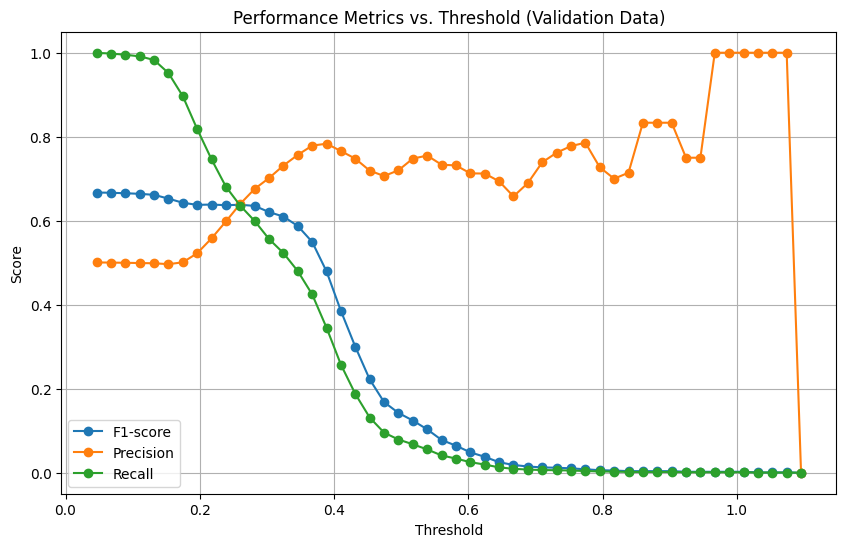

Optimal Threshold (based on Validation): 0.04612450066101616
104/104 [==============================] - 0s 359us/step

Validation Data Evaluation:
Validation F1-score: 0.6671664167916042
Validation Precision: 0.5006562910181886
Validation Recall: 0.9996256083863722

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2663
         1.0       0.50      1.00      0.67      2671

    accuracy                           0.50      5334
   macro avg       0.25      0.50      0.33      5334
weighted avg       0.25      0.50      0.33      5334


Test Data Evaluation:
Test F1-score: 0.6666666666666666
Test Precision: 0.5
Test Recall: 1.0

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3327
         1.0       0.50      1.00      0.67      3327

    accuracy                           0.50      6654
   macro avg       0.25      0.

/home/park/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/park/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/park/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt

# 데이터 준비
X_train = train_normal_features  # Train 정상 데이터
X_val = validation_normal_features  # Validation 정상 데이터
X_val_abnormal = validation_abnormal_features  # Validation 비정상 데이터
X_test = test_normal_features  # Test 정상 데이터
X_test_abnormal = test_abnormal_features  # Test 비정상 데이터

# Autoencoder 모델 정의
input_dim = X_train.shape[1]  # feature 개수
encoding_dim = 2  # 압축된 차원 (조정 가능)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder 모델 생성
autoencoder = models.Model(input_layer, decoded)

# 모델 컴파일
autoencoder.compile(optimizer="adam", loss="mse")

# 모델 학습
history = autoencoder.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val),  # Validation 데이터로 평가
    verbose=1
)

# 모델 학습 완료
print("Training Complete!")

# Validation 데이터 복원
reconstructed_val = autoencoder.predict(X_val)
reconstructed_val_abnormal = autoencoder.predict(X_val_abnormal)

# 재구성 오차 계산 => Validation 데이터
val_reconstruction_error = np.mean((X_val - reconstructed_val)**2, axis=1)
val_abnormal_reconstruction_error = np.mean((X_val_abnormal - reconstructed_val_abnormal)**2, axis=1)

# Combine Validation 데이터 라벨 및 Reconstruction Errors
val_labels = np.zeros(len(val_reconstruction_error))  # 정상 라벨 (0)
val_abnormal_labels = np.ones(len(val_abnormal_reconstruction_error))  # 비정상 라벨 (1)
val_true_labels = np.concatenate([val_labels, val_abnormal_labels])
val_all_reconstruction_errors = np.concatenate([val_reconstruction_error, val_abnormal_reconstruction_error])

# 임계값 범위 설정
thresholds = np.linspace(np.min(val_all_reconstruction_errors), np.max(val_all_reconstruction_errors), 50)

# 성능 지표 저장
f1_scores = []
precisions = []
recalls = []

# 각 Threshold에 대한 F1-score, Precision, Recall 계산
for threshold in thresholds:
    val_predicted_labels = (val_all_reconstruction_errors > threshold).astype(int)
    f1_scores.append(f1_score(val_true_labels, val_predicted_labels))
    precisions.append(precision_score(val_true_labels, val_predicted_labels))
    recalls.append(recall_score(val_true_labels, val_predicted_labels))

# Validation 성능 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Threshold (Validation Data)')
plt.legend()
plt.grid(True)
plt.show()

# Validation 기반 최적 Threshold 설정
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold (based on Validation): {optimal_threshold}")

# Test 데이터 복원
reconstructed_test = autoencoder.predict(X_test)
reconstructed_test_abnormal = autoencoder.predict(X_test_abnormal)

# Test 데이터 재구성 오차 계산
test_reconstruction_error = np.mean((X_test - reconstructed_test)**2, axis=1)
test_abnormal_reconstruction_error = np.mean((X_test_abnormal - reconstructed_test_abnormal)**2, axis=1)

# Combine Test 데이터 라벨 및 Reconstruction Errors
test_labels = np.zeros(len(test_reconstruction_error))  # 정상 라벨 (0)
test_abnormal_labels = np.ones(len(test_abnormal_reconstruction_error))  # 비정상 라벨 (1)
test_true_labels = np.concatenate([test_labels, test_abnormal_labels])
test_all_reconstruction_errors = np.concatenate([test_reconstruction_error, test_abnormal_reconstruction_error])

# Test 데이터 예측 라벨 생성
test_predicted_labels = (test_all_reconstruction_errors > optimal_threshold).astype(int)

# Validation 데이터 성능 평가
print("\nValidation Data Evaluation:")
val_predicted_labels = (val_all_reconstruction_errors > optimal_threshold).astype(int)
val_f1 = f1_score(val_true_labels, val_predicted_labels)
val_precision = precision_score(val_true_labels, val_predicted_labels)
val_recall = recall_score(val_true_labels, val_predicted_labels)
print("Validation F1-score:", val_f1)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("\nValidation Classification Report:")
print(classification_report(val_true_labels, val_predicted_labels))

# Test 데이터 성능 평가
print("\nTest Data Evaluation:")
test_f1 = f1_score(test_true_labels, test_predicted_labels)
test_precision = precision_score(test_true_labels, test_predicted_labels)
test_recall = recall_score(test_true_labels, test_predicted_labels)
print("Test F1-score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("\nTest Classification Report:")
print(classification_report(test_true_labels, test_predicted_labels))


Epoch 1/50
332/332 [==============================] - 1s 2ms/step - loss: 0.1154 - val_loss: 0.0694
Epoch 2/50
332/332 [==============================] - 0s 827us/step - loss: 0.0425 - val_loss: 0.0242
Epoch 3/50
332/332 [==============================] - 0s 849us/step - loss: 0.0153 - val_loss: 0.0095
Epoch 4/50
332/332 [==============================] - 0s 830us/step - loss: 0.0070 - val_loss: 0.0054
Epoch 5/50
332/332 [==============================] - 0s 797us/step - loss: 0.0047 - val_loss: 0.0042
Epoch 6/50
332/332 [==============================] - 0s 818us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 7/50
332/332 [==============================] - 0s 825us/step - loss: 0.0038 - val_loss: 0.0036
Epoch 8/50
332/332 [==============================] - 0s 783us/step - loss: 0.0036 - val_loss: 0.0035
Epoch 9/50
332/332 [==============================] - 0s 823us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 10/50
332/332 [==============================] - 0s 824us/step - loss: 0.0032 

/home/park/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


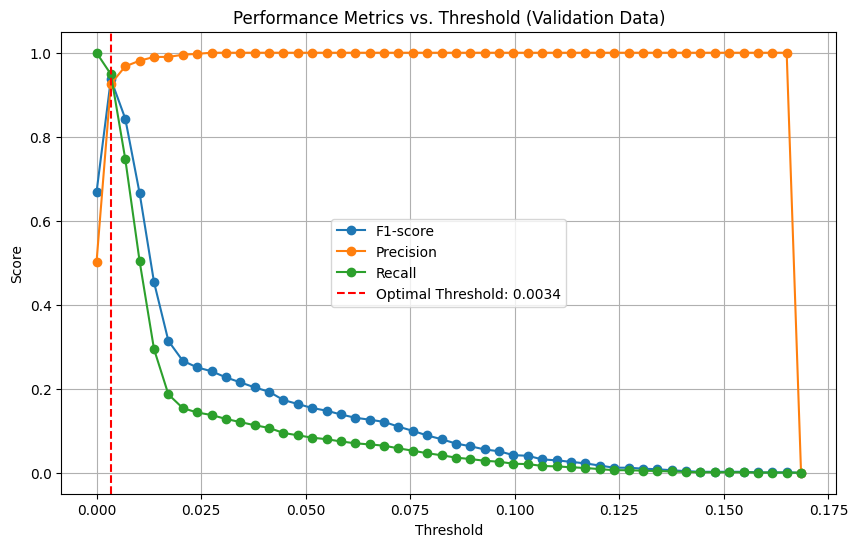

104/104 [==============================] - 0s 468us/step

Test Data Evaluation:
Test F1-score: 0.9536651843351026
Test Precision: 0.9121844127332601
Test Recall: 0.9990982867448152

Test Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      3327
         1.0       0.91      1.00      0.95      3327

    accuracy                           0.95      6654
   macro avg       0.96      0.95      0.95      6654
weighted avg       0.96      0.95      0.95      6654



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt

# 데이터 준비
# train_normal_features와 validation_normal_features, test_normal_features에서 variance, rms, skewness 피처만 선택
X_train = train_normal_features[:, [1, 2, 3]]  # Train 정상 데이터
X_val = validation_normal_features[:, [1, 2, 3]]  # Validation 정상 데이터
X_val_abnormal = validation_abnormal_features[:, [1, 2, 3]]  # Validation 비정상 데이터
X_test = test_normal_features[:, [1, 2, 3]]  # Test 정상 데이터
X_test_abnormal = test_abnormal_features[:, [1, 2, 3]]  # Test 비정상 데이터

# Autoencoder 모델 정의
input_dim = X_train.shape[1]  # feature 개수 (3개)
encoding_dim = 2  # 압축된 차원 (조정 가능)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder 모델 생성
autoencoder = models.Model(input_layer, decoded)

# 모델 컴파일
autoencoder.compile(optimizer="adam", loss="mse")

# 모델 학습
history = autoencoder.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val),  # Validation 데이터로 평가
    verbose=1
)

# 모델 학습 완료
print("Training Complete!")

# Validation 데이터 복원
reconstructed_val = autoencoder.predict(X_val)
reconstructed_val_abnormal = autoencoder.predict(X_val_abnormal)

# 재구성 오차 계산 => Validation 데이터
val_reconstruction_error = np.mean((X_val - reconstructed_val)**2, axis=1)
val_abnormal_reconstruction_error = np.mean((X_val_abnormal - reconstructed_val_abnormal)**2, axis=1)

# Combine Validation 데이터 라벨 및 Reconstruction Errors
val_labels = np.zeros(len(val_reconstruction_error))  # 정상 라벨 (0)
val_abnormal_labels = np.ones(len(val_abnormal_reconstruction_error))  # 비정상 라벨 (1)
val_true_labels = np.concatenate([val_labels, val_abnormal_labels])
val_all_reconstruction_errors = np.concatenate([val_reconstruction_error, val_abnormal_reconstruction_error])

# 임계값 범위 설정 (Validation 데이터 기반)
# thresholds = np.linspace(np.min(val_all_reconstruction_errors), np.max(val_all_reconstruction_errors), 50)
thresholds = 0.0034380944151149576
# 성능 지표 저장을 위한 리스트 초기화
f1_scores = []
precisions = []
recalls = []

# 각 임계값에 대해 성능 지표 계산
for threshold in thresholds:
    predicted_labels = (val_all_reconstruction_errors > threshold).astype(int)
    f1_scores.append(f1_score(val_true_labels, predicted_labels))
    precisions.append(precision_score(val_true_labels, predicted_labels))
    recalls.append(recall_score(val_true_labels, predicted_labels))

# Validation 데이터 기반 최적 Threshold 선택
optimal_threshold = thresholds[np.argmax(f1_scores)]
optimal_f1_score = np.max(f1_scores)
optimal_precision = precisions[np.argmax(f1_scores)]
optimal_recall = recalls[np.argmax(f1_scores)]

print(f"Optimal Threshold (based on Validation): {optimal_threshold}")
print(f"Optimal F1-score: {optimal_f1_score}")
print(f"Precision at Optimal Threshold: {optimal_precision}")
print(f"Recall at Optimal Threshold: {optimal_recall}")

# Validation 성능 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Threshold (Validation Data)')
plt.legend()
plt.grid(True)
plt.show()

# Test 데이터 복원
reconstructed_test = autoencoder.predict(X_test)
reconstructed_test_abnormal = autoencoder.predict(X_test_abnormal)

# 재구성 오차 계산 => Test 데이터
test_reconstruction_error = np.mean((X_test - reconstructed_test)**2, axis=1)
test_abnormal_reconstruction_error = np.mean((X_test_abnormal - reconstructed_test_abnormal)**2, axis=1)

# Combine Test 데이터 라벨 및 Reconstruction Errors
test_labels = np.zeros(len(test_reconstruction_error))  # 정상 라벨 (0)
test_abnormal_labels = np.ones(len(test_abnormal_reconstruction_error))  # 비정상 라벨 (1)
test_true_labels = np.concatenate([test_labels, test_abnormal_labels])
test_all_reconstruction_errors = np.concatenate([test_reconstruction_error, test_abnormal_reconstruction_error])

# Test 데이터 예측 라벨 생성
test_predicted_labels = (test_all_reconstruction_errors > optimal_threshold).astype(int)

# Test 데이터 성능 평가
print("\nTest Data Evaluation:")
test_f1 = f1_score(test_true_labels, test_predicted_labels)
test_precision = precision_score(test_true_labels, test_predicted_labels)
test_recall = recall_score(test_true_labels, test_predicted_labels)
print("Test F1-score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("\nTest Classification Report:")
print(classification_report(test_true_labels, test_predicted_labels))

